## ROC Functions 

In [40]:
import warnings
warnings.filterwarnings('ignore')

In [78]:
import pandas as pd
import numpy as np
# import os

from ipywidgets import IntProgress
from IPython.display import display, HTML
from matplotlib import pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import CubicSpline


#Data Type for ROC graphs (Data name, False Positives, True Positives, False Negatives, True Negatives)
def ROC_DATA(label, FP='-', TP='-', FN='-', TN='-', THRESHOLD='-'):
    obj = {'Label':label }
    if(not(FP is '-')):
        obj['FP'] = FP
    if(not(FN is '-')):
        obj['FN'] = FN
    if(not(TP is '-')):
        obj['TP'] = TP
    if(not(TN is '-')):
        obj['TN'] = TN
    if(not(THRESHOLD is '-')):
        obj['THRESHOLD'] = THRESHOLD
    return obj



#makes ROC_DATA for a all columns in a df
def getRate(df, col, label='Default'):
    FP, TP = [], []
    FN, TN = [], []
    THRESHOLD = []
    for i in range(0, 100):
        threshold=i/100.
        THRESHOLD.append(threshold)
        FP.append(len(df[(df[col]<threshold) & (df['Success']==1)])/len(df[df['Success']==1]))
        TP.append(len(df[(df[col]<threshold) & (df['Success']==0)])/len(df[df['Success']==0]))
        FN.append(len(df[(df[col]>threshold) & (df['Success']==0)])/len(df[df['Success']==0]))
        TN.append(len(df[(df[col]>threshold) & (df['Success']==1)])/len(df[df['Success']==1]))
    return ROC_DATA(label, TP=TP, FP=FP, TN=TN, FN=FN, THRESHOLD=THRESHOLD)

#Plot a single ROC_DATA with THRESHOLD as a second x-axis
def plotRocThreshold(rocData):
    fig = plt.figure()
    fig.set_size_inches(5, 5)
    ax = fig.add_subplot(1,1,1)
    
    d = skimROC_Data(rocData, addTresh=True)
    label = d['Label']
    
    FP, TP = d['FP'], d['TP']
    THRESHOLD = d['THRESHOLD']

    ax.plot(FP,TP,'-' ,label = "FP", alpha=.8, color='black')
    ax.plot(THRESHOLD,TP,'-' ,label = "Threshold", color='red', linewidth = .5)

    ax.set_xlabel('%')
    ax.set_xlim(0,1)
    ax.set_ylabel('TP %')
    ax.set_ylim(0,1)
    ax.set_title(label+ " ROC + Thresholds")
    ax.grid(color='black', linestyle='-', linewidth=1, alpha=.5)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend()


#Plot an array of ROC_DATA
def plotRocs(rocObjArray):
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    ax = fig.add_subplot(1,1,1)
    for rocData in rocObjArray:
        d = skimROC_Data(rocData)
        label = d['Label']
        FP, TP = d['FP'], d['TP']
        ax.plot(FP,TP,'-' ,label = label,zorder = -32, alpha=.5)
    handles, labels = ax.get_legend_handles_labels()
    display = (0,71)
    ax.set_xlabel('FP Rate')
    ax.set_xlim(0,1)
    ax.set_ylabel('TP Rate')
    ax.set_ylim(0,1)
    ax.grid(color='black', linestyle='-', linewidth=1, alpha=.5)
    ax.set_title('ROC Curve Compliation')
    ax.legend()
    
    
#Limits columns in a DF to  particular value
def limitVal(df, ignore = ['Success'], N = 1.):
    for c in df.drop(columns=ignore).columns:
#         df[c].loc[df[c] >= N] = N
#         print(df[c].dtype)
        if(not (df[c].dtype == 'bool')):
            df[c] = df[c].where(df[c] <= 1., 1.) 
    return df


#Takes the average of all columns in a df
def avgVal(df, ignore = ['Success'], colName = "AvgPred", JUST_PREDS=False):
#     if(JUST_PREDS):
#         for col in df.columns:
#             if(not(col[:4]=='Pred')):
#                 ignore.append(col)
    df[colName] = df.drop(columns=ignore).mean(axis=1)
    return df

def skimROC_Data(d, addTresh=False):
    x, y = [], []
    t = []
    for i in range(0, len(d['FP'])):
        curX, curY = d['FP'][i], d['TP'][i]
        if(addTresh):
            curT = d['THRESHOLD'][i]
        if(len(x) == 0):
            x.append(curX)
            y.append(curY)
            if(addTresh):
                t.append(curT)
        elif(not curX == x[-1:][0]):
            x.append(curX)
            y.append(curY)
            if(addTresh):
                t.append(curT)
    data = {"Label":d['Label'], 'FP':x, 'TP':y}
    if(addTresh):
        data['THRESHOLD'] = t
    return data

def rocPercent(roc):
    data = skimROC_Data(roc)
    f = InterpolatedUnivariateSpline(data['FP'], data['TP'], k=1)
    plt.plot(f)
    return data['Label'] + "'s Integral is: "+str(f.integral(0.,1.))

def rocPercents(rocData):
    for roc in rocData:
        pct = rocPercent(roc)
        print(pct)


## Forest Functions

In [42]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

#Samples DF for an approximate numnber of rows  (Needed for balanceDF)
def cutDF(df, intendedNumber):
    df = df.sample(frac=intendedNumber/len(df), replace=True)
    return df

#Returns DF with 50/50 split on specified binary column
def balanceDF(df, colName, numberOfEach = 0):
    failDF = df[df[colName]==False]
    successDF = df[df[colName]==True]
    if(numberOfEach == 0):
        maxContestsForBalance = min(len(successDF), len(failDF))
        numberOfEach = int(maxContestsForBalance*.1)
    combinedDF = pd.concat([cutDF(successDF, numberOfEach), cutDF(failDF, numberOfEach)])
    return combinedDF

#Splits a df into two parts, for testing and training
def splitTrainingTesting(df, percentTrain, TYPE='None', basedOnVault=False):
    if(not basedOnVault):
        df = df.copy(deep=True)
        if(TYPE=="CLF"):
            df['Success'] = df['Success'].astype('int')
        elif(TYPE=='REGR'):
            df['Success'] = df['Success'].astype('float')
        df['is_train'] = np.random.uniform(0, 1, len(df)) <= percentTrain
        trainDF, testDF = df[df['is_train']==True], df[df['is_train']==False]
        df = df.drop(columns=['is_train'], axis=1)
        trainDF = trainDF.drop(['is_train'], axis=1)
        testDF = testDF.drop(['is_train'], axis=1)
        return trainDF, testDF
    else:
        nonVault = pd.merge(nonVaultDF, df, on='ContestId', how='left')
        vault = df[~df.index.isin(nonVault.index)].dropna()
#         return len(vault), len(nonVault)
        numTrain = len(nonVault)
        numTest = int((1-percentTrain)*numTrain)
        vault.sample(n=numTest, random_state=1)
        return nonVault, vault.sample(n=numTest, random_state=1)


#Simple wrapper for a making a classifier
def classifierWrapper(trainDF, classifierType, balanced=True):
    trainDF = trainDF.copy(deep=True)
    if(balanced):
        trainDF = balanceDF(trainDF, 'Success')
    clf = makeAndTrainCLF(trainDF, classifierType)
    columns = trainDF.columns.drop('Success')
    return {"clf":clf, "cols":columns}

#Trains a classifier of the provided 
def makeAndTrainCLF(trainDF, classifierType, successCol = 'Success'): ####################
    clf = classifierType()
    clf.fit(trainDF[trainDF.columns.drop(successCol)], trainDF[successCol].astype('int'))
    return clf


def EnsembleWithMinAcc(trainDF, classifierType, balanced=True, numCLF = 20, accuracy=0.):
    CLFS = []
    for i in range(0, numCLF):
        currAcc = -1.
        while(currAcc < accuracy):
            clf = classifierWrapper(trainDF, RandomForestClassifier, balanced=balanced)
            currAcc = accuracy_score(clf['clf'].predict(trainDF[clf['cols']]), trainDF['Success'])
        CLFS.append(clf)
    return CLFS

def getEnsPred(testDF, CLFS):
    rDF = testDF[['Success']].copy(deep=True)
    count = 0
    for CLF in CLFS:
        count+=1
        classifier, columns = CLF['clf'], CLF['cols']
        rDF['CLF'+str(count)] = classifier.predict(testDF[columns])
    return rDF

### Data Files for ROC

In [43]:
fullContests = pd.read_csv('data/WorkingData.csv').set_index('ContestId')

In [44]:
# Percent Full at 4 hours out
baselineDF = pd.read_csv('data/baseline.csv').drop(columns=['Unnamed: 0'])

# Meta Data file
metaDataDF = pd.read_csv('data/MetaData.csv')

# Kalman Filter
kfResultsDF = pd.read_csv('data/KF_Results.csv')
kfsResultsDF = pd.read_csv('data/KF_Scaled_Results.csv')

# Linear Regression
lrResultsDF = pd.read_csv('data/LR_Results.csv')
lrsResultsDF = pd.read_csv('data/LR_Scaled_Results.csv')

In [45]:
trainDF = pd.read_csv("dataVault/train.csv").set_index('ContestId')
testDF = pd.read_csv("dataVault/vault1.csv").set_index('ContestId')
print("Number of contests in trainDF:",len(trainDF))
print("Number of contests in testDF:",len(testDF))

Number of contests in trainDF: 378799
Number of contests in testDF: 73460


### Calculating ROC_DATA

Baseline ROC Generation

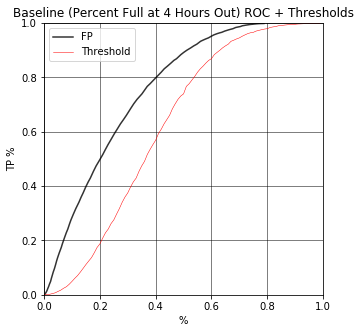

In [46]:
# print("... Calculating Baseline 4-hours-out Prediction")
baselineRates = getRate(baselineDF, 'FourHoursOut_Scaled', label='Baseline (Percent Full at 4 Hours Out)')
plotRocThreshold(baselineRates)

Meta Data ROC Generation

In [47]:
metaColumns = list(metaDataDF.columns.drop('ContestId'))
metaColumns.append('Success')
metaTrain, metaTest = trainDF[metaColumns], testDF[metaColumns]

In [61]:
metaCLFS = EnsembleWithMinAcc(limitVal(metaTrain), RandomForestClassifier, accuracy = .6)
metaPreds = avgVal(getEnsPred(limitVal(metaTest), metaCLFS))

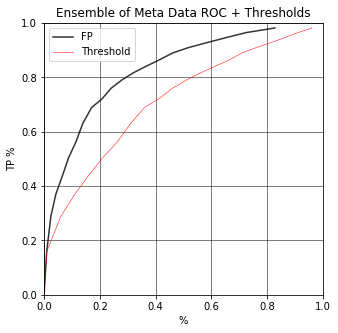

In [62]:
metaEnsembleRates =  getRate(metaPreds, 'AvgPred', label='Ensemble of Meta Data')
plotRocThreshold(metaEnsembleRates)

Kalman Filter ROC Generation

In [50]:
kfColumns = list(kfResultsDF.columns.drop('ContestId'))
kfColumns.append('Success')
kfTrain, kfTest = trainDF[kfColumns], testDF[kfColumns]

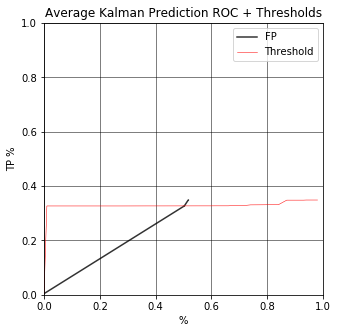

In [74]:
kfAvgRate = getRate(avgVal(limitVal(kfTest, N=1.), JUST_PREDS=True), 'AvgPred', label='Average Kalman Prediction')
plotRocThreshold(kfAvgRate)

In [57]:
kfCLFS = EnsembleWithMinAcc(limitVal(kfTrain, N=1.), RandomForestClassifier, accuracy = .6)
kfPreds = avgVal(getEnsPred(limitVal(kfTest, N=1.), kfCLFS))

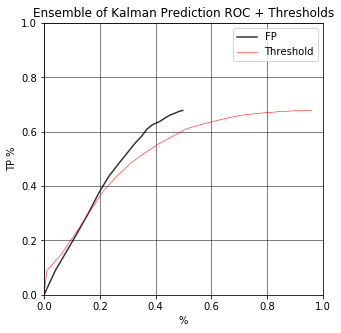

In [58]:
kfEnsembleRates =  getRate(kfPreds, 'AvgPred', label='Ensemble of Kalman Prediction')
plotRocThreshold(kfEnsembleRates)

Linear Regression ROC Generation

In [64]:
lrColumns = list(lrResultsDF.columns.drop('ContestId'))
lrColumns.append('Success')
lrTrain, lrTest = trainDF[lrColumns], testDF[lrColumns]

sup


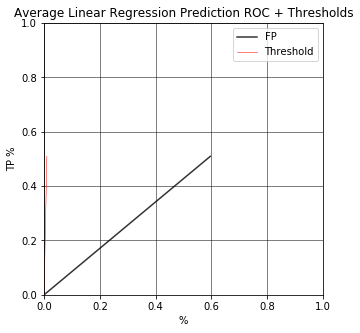

In [72]:
lrAvgRate = getRate(avgVal(limitVal(lrTest, N=1.), JUST_PREDS=True), 'AvgPred', label='Average Linear Regression Prediction')
plotRocThreshold(lrAvgRate)

In [70]:
lrCLFS = EnsembleWithMinAcc(limitVal(lrTrain, N=1.), RandomForestClassifier, accuracy = .6)
lrPreds = avgVal(getEnsPred(limitVal(lrTest, N=1.), lrCLFS))

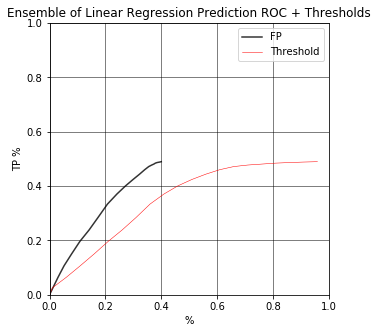

In [71]:
lrEnsembleRates =  getRate(lrPreds, 'AvgPred', label='Ensemble of Linear Regression Prediction')
plotRocThreshold(lrEnsembleRates)

### Scaled

In [75]:
kfsColumns = list(kfsResultsDF.columns.drop('ContestId'))
kfsColumns.append('Success')
kfsTrain, kfsTest = trainDF[kfsColumns], testDF[kfsColumns]

In [76]:
# kfsAvgRate = getRate(avgVal(limitVal(kfsTest, N=1.)), 'AvgPred', label='Average SCALED Kalman Prediction')
# plotRocThreshold(kfsAvgRate)

In [79]:
kfsCLFS = EnsembleWithMinAcc(limitVal(kfsTrain, N=1.), RandomForestClassifier, accuracy = .6)
kfsPreds = avgVal(getEnsPred(limitVal(kfsTest, N=1.), kfsCLFS))

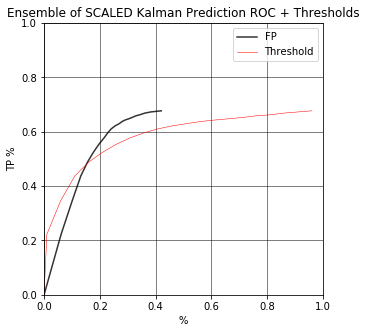

In [80]:
kfsEnsembleRates =  getRate(kfsPreds, 'AvgPred', label='Ensemble of SCALED Kalman Prediction')
plotRocThreshold(kfsEnsembleRates)

In [81]:
lrsColumns = list(lrsResultsDF.columns.drop('ContestId'))
lrsColumns.append('Success')
lrsTrain, lrsTest = trainDF[lrsColumns], testDF[lrsColumns]

In [82]:
lrsCLFS = EnsembleWithMinAcc(limitVal(lrsTrain, N=1.), RandomForestClassifier, accuracy = .6)
lrsPreds = avgVal(getEnsPred(limitVal(lrsTest, N=1.), lrsCLFS))

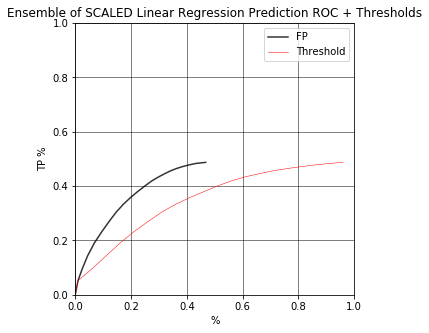

In [83]:
lrsEnsembleRates =  getRate(lrsPreds, 'AvgPred', label='Ensemble of SCALED Linear Regression Prediction')
plotRocThreshold(lrsEnsembleRates)

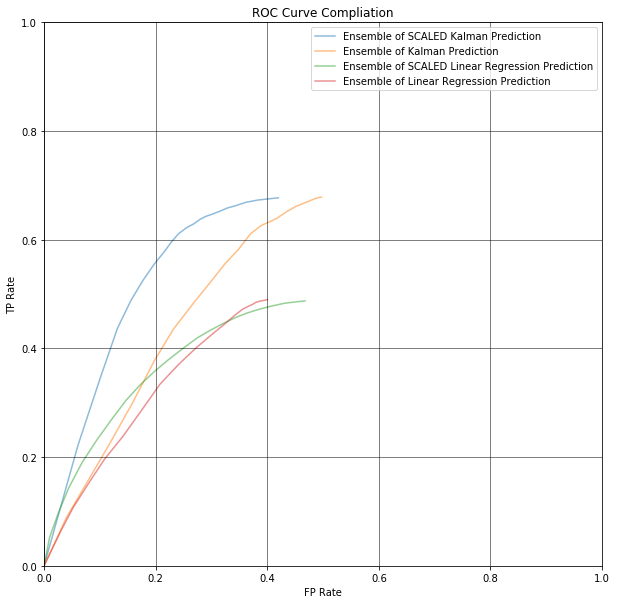

In [84]:
plotRocs([kfsEnsembleRates, kfEnsembleRates, lrsEnsembleRates, lrEnsembleRates])

### Merging Predictors

In [86]:
lrkfColumns = list(set(kfColumns+lrColumns))
lrkfTrain, lrkfTest = trainDF[lrkfColumns], testDF[lrkfColumns]

In [87]:
lrkfCLFS = EnsembleWithMinAcc(limitVal(lrkfTrain, N=1.), RandomForestClassifier, accuracy = .6)
lrkfPreds = avgVal(getEnsPred(limitVal(lrkfTest, N=1.), lrkfCLFS))

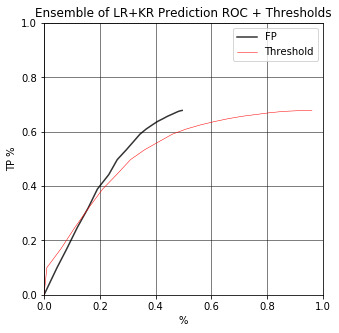

In [88]:
lrkfEnsembleRates =  getRate(lrkfPreds, 'AvgPred', label='Ensemble of LR+KR Prediction')
plotRocThreshold(lrkfEnsembleRates)

In [89]:
lrkfsColumns = list(set(kfsColumns+lrsColumns))
lrkfsTrain, lrkfsTest = trainDF[lrkfsColumns], testDF[lrkfsColumns]

In [90]:
lrkfsCLFS = EnsembleWithMinAcc(limitVal(lrkfsTrain, N=1.), RandomForestClassifier, accuracy = .6)
lrkfsPreds = avgVal(getEnsPred(limitVal(lrkfsTest, N=1.), lrkfsCLFS))

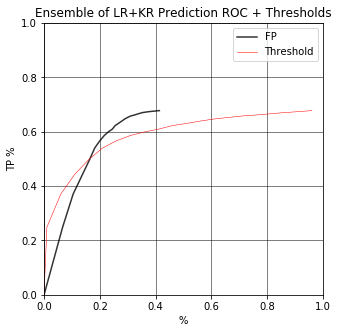

In [91]:
lrkfsEnsembleRates =  getRate(lrkfsPreds, 'AvgPred', label='Ensemble of LR+KR Prediction')
plotRocThreshold(lrkfsEnsembleRates)

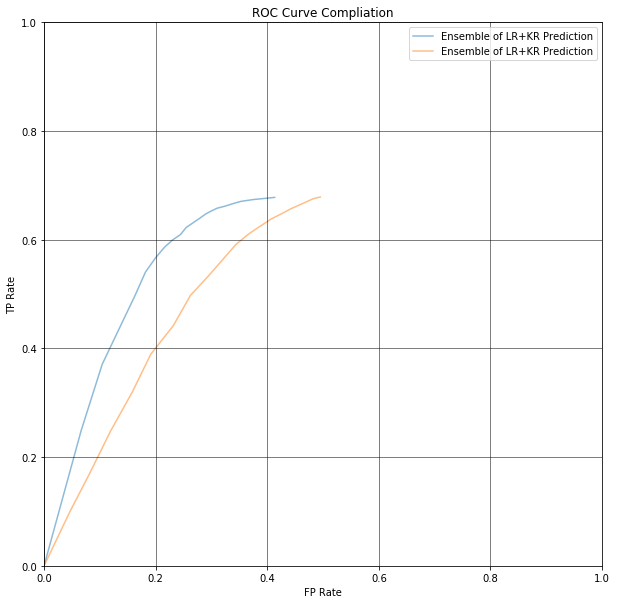

In [92]:
plotRocs([lrkfsEnsembleRates, lrkfEnsembleRates])

### Adding Meta Data

In [94]:
lrkfMetaColumns = list(set(metaColumns+lrColumns+kfColumns))
lrkfMetaTrain, lrkfMetaTest = trainDF[lrkfMetaColumns], testDF[lrkfMetaColumns]
lrkfMetaTrain, lrkfMetaTest = limitVal(lrkfMetaTrain, ignore=metaColumns,  N=1.).dropna(), limitVal(lrkfMetaTest, ignore=metaColumns,  N=1.).dropna()

In [96]:
lrkfMetaCLFS = EnsembleWithMinAcc(lrkfMetaTrain, RandomForestClassifier, accuracy = .6)
lrkfMetaPreds = avgVal(getEnsPred(lrkfMetaTest, lrkfMetaCLFS))

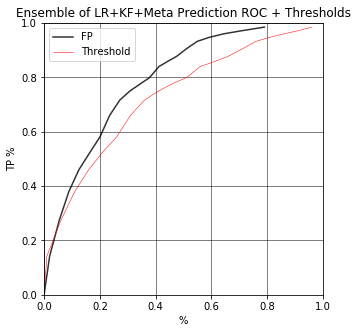

In [97]:
lrkfMetaEnsembleRates =  getRate(lrkfMetaPreds, 'AvgPred', label='Ensemble of LR+KF+Meta Prediction')
plotRocThreshold(lrkfMetaEnsembleRates)

In [98]:
lrkfsMetaColumns = list(set(metaColumns+lrsColumns+kfsColumns))
lrkfsMetaTrain, lrkfsMetaTest = trainDF[lrkfsMetaColumns], testDF[lrkfsMetaColumns]
lrkfsMetaTrain, lrkfsMetaTest = limitVal(lrkfsMetaTrain, ignore=metaColumns,  N=1.).dropna(), limitVal(lrkfsMetaTest, ignore=metaColumns,  N=1.).dropna()

In [99]:
lrkfsMetaCLFS = EnsembleWithMinAcc(lrkfsMetaTrain, RandomForestClassifier, accuracy = .6)
lrkfsMetaPreds = avgVal(getEnsPred(lrkfsMetaTest, lrkfsMetaCLFS))

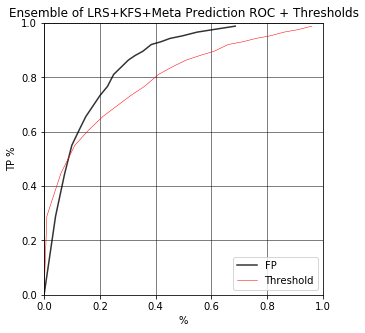

In [100]:
lrkfsMetaEnsembleRates =  getRate(lrkfsMetaPreds, 'AvgPred', label='Ensemble of LRS+KFS+Meta Prediction')
plotRocThreshold(lrkfsMetaEnsembleRates)

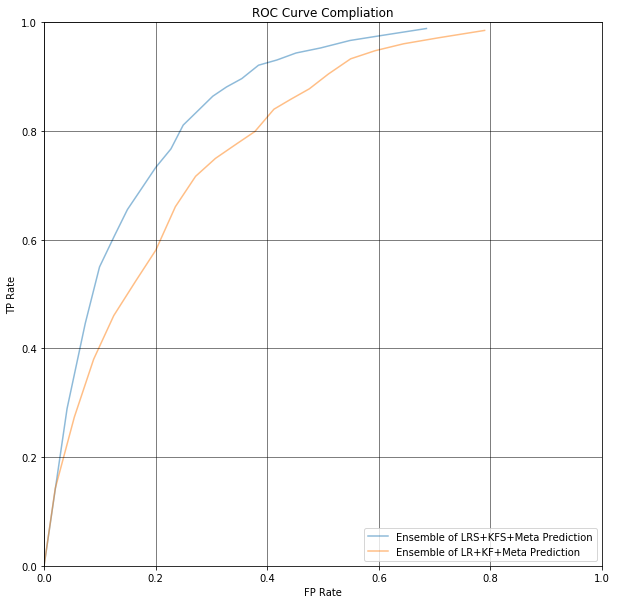

In [101]:
plotRocs([lrkfsMetaEnsembleRates, lrkfMetaEnsembleRates])

### Pacer Data

In [102]:
pacerData = pd.read_csv('data/DK_Pacer_Success.csv').set_index('ContestId')
pacerData.columns

Index(['Success', 'PacerSuccess'], dtype='object')

In [103]:
pacerRate = getRate(pacerData, 'PacerSuccess', label='Pacer Prediction')

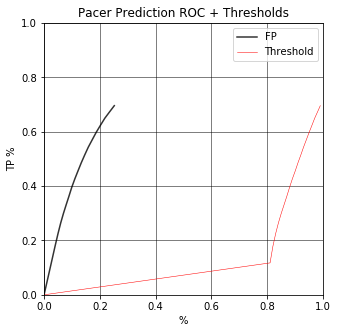

In [104]:
plotRocThreshold(pacerRate)

In [105]:
pTrain = pd.merge(pacerData, trainDF[metaColumns].drop(columns=['Success']), on='ContestId', how='inner').dropna()
pTest = pd.merge(pacerData, testDF[metaColumns].drop(columns=['Success']), on='ContestId', how='inner').dropna()

In [106]:
pCLFS = EnsembleWithMinAcc(pTrain, RandomForestClassifier, accuracy = .6)
pPreds = avgVal(getEnsPred(pTest, pCLFS))
pEnsembleRates =  getRate(pPreds, 'AvgPred', label='Ensemble of Pacer+Meta Prediction')

In [107]:
fpTrain = pd.merge(pacerData, trainDF[list(set(metaColumns+kfColumns))].drop(columns=['Success']), on='ContestId', how='inner').dropna()
fpTest = pd.merge(pacerData, testDF[list(set(metaColumns+kfColumns))].drop(columns=['Success']), on='ContestId', how='inner').dropna()
fpTrain = limitVal(fpTrain, ignore=metaColumns, N=1.)
fpTest = limitVal(fpTest, ignore=metaColumns, N=1.)

In [108]:
fpCLFS = EnsembleWithMinAcc(fpTrain, RandomForestClassifier, accuracy = .6)
fpPreds = avgVal(getEnsPred(fpTest, fpCLFS))
fpEnsembleRates =  getRate(fpPreds, 'AvgPred', label='Ensemble of Pacer+KF+Meta Prediction')

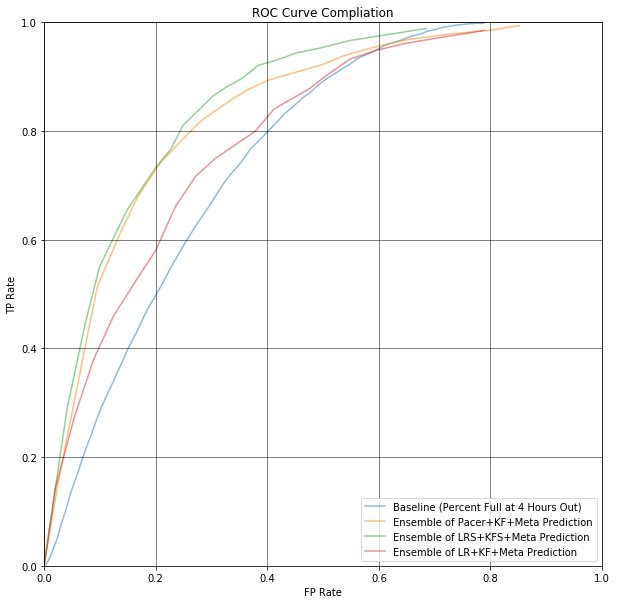

In [113]:
plotRocs([baselineRates, fpEnsembleRates, lrkfsMetaEnsembleRates, lrkfMetaEnsembleRates])

### Big Contests

In [116]:
combinedColumns = list(set(metaColumns+kfsColumns+lrsColumns))
combinedTrain, combinedTest = trainDF[combinedColumns], testDF[combinedColumns]
combinedTrain, combinedTest = limitVal(combinedTrain, ignore=metaColumns,  N=1.).dropna(), limitVal(combinedTest, ignore=metaColumns,  N=1.).dropna()

In [117]:
cCLFS = EnsembleWithMinAcc(combinedTrain, RandomForestClassifier, accuracy = .6)

In [118]:
threshold = 1000
bigIds = fullContests[fullContests['MaxNumberPlayers']>threshold][[]]
bigTest = combinedTest[combinedTest.index.isin(bigIds.index)]
smallIds = fullContests[fullContests['MaxNumberPlayers']<threshold][[]]
smallTest = combinedTest[combinedTest.index.isin(smallIds.index)]

In [119]:
bigRate = getRate(avgVal(getEnsPred(bigTest, cCLFS)), 'AvgPred', label=('Ensemble on Contests > '+str(threshold)))
smallRate = getRate(avgVal(getEnsPred(smallTest, cCLFS)), 'AvgPred', label=('Ensemble on Contests < '+str(threshold)))
normalRate = getRate(avgVal(getEnsPred(combinedTest, cCLFS)), 'AvgPred', label='Ensemble on all Contests')

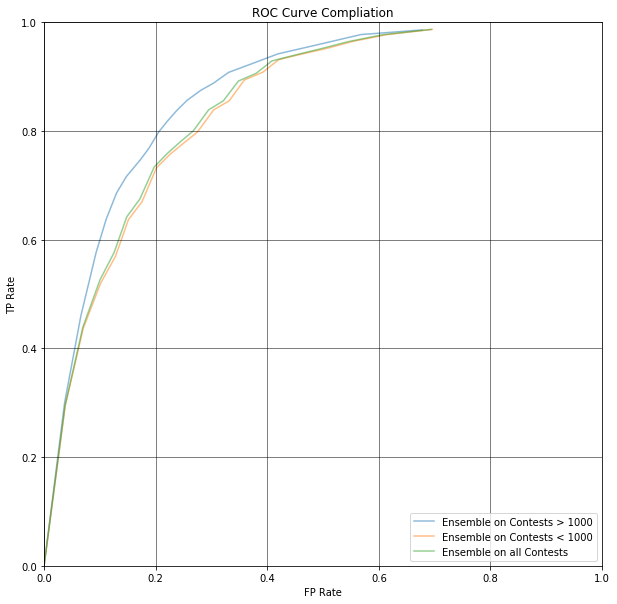

In [120]:
plotRocs([bigRate, smallRate, normalRate])

### Contest Comparison

In [121]:
combinedColumns = list(set(metaColumns+kfsColumns+lrsColumns))
combinedTrain, combinedTest = trainDF[combinedColumns], testDF[combinedColumns]
combinedTrain, combinedTest = limitVal(combinedTrain, ignore=metaColumns,  N=1.).dropna(), limitVal(combinedTest, ignore=metaColumns,  N=1.).dropna()

In [122]:
sportCLFS = EnsembleWithMinAcc(combinedTrain, RandomForestClassifier, accuracy = .6)

In [123]:
sportIds = []
for sport in fullContests['SportName'].unique():
    sportDF = fullContests[fullContests['SportName']==sport][[]]
    sportIds.append({'Sport':sport, 'df':sportDF})

In [124]:
for sportObj in sportIds:
    sportTestDF = combinedTest[combinedTest.index.isin(sportObj['df'].index)]
    sportObj['testDF'] = sportTestDF
    print(sportObj['Sport']+":\t", len(sportTestDF))

NAS:	 797
CFB:	 5199
MLB:	 13317
NFL:	 13994
SOCC:	 46
PGA:	 97
MMA:	 735
LOL:	 1149
NHL:	 8474
NBA:	 20435
SOC:	 4014
CBB:	 1202
GOLF:	 2843
CFL:	 229
EL:	 176
TEN:	 491


In [125]:
for sportObj in sportIds:
    sportObj['preds'] = avgVal(getEnsPred(sportObj['testDF'], sportCLFS))
    sportObj['rates'] = getRate(sportObj['preds'], 'AvgPred', label=sportObj['Sport'])

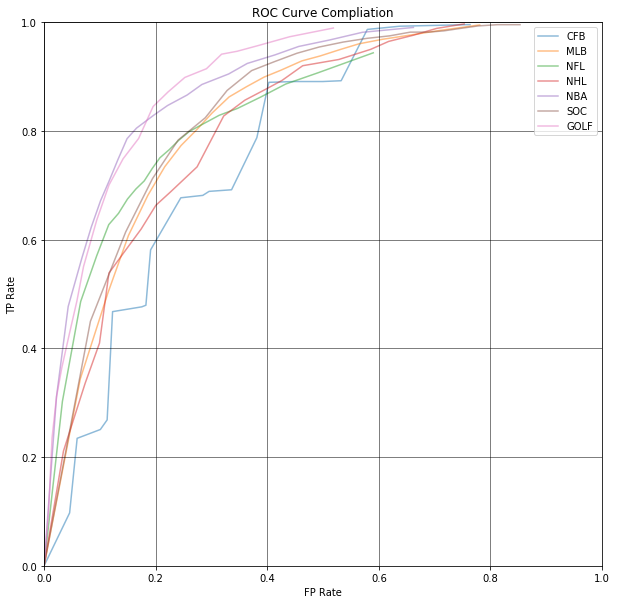

In [126]:
threshold = 2000
sportRates = []
for sportObj in sportIds:
    if(len(sportObj['testDF'])>threshold):
        sportRates.append(sportObj['rates'])
plotRocs(sportRates)

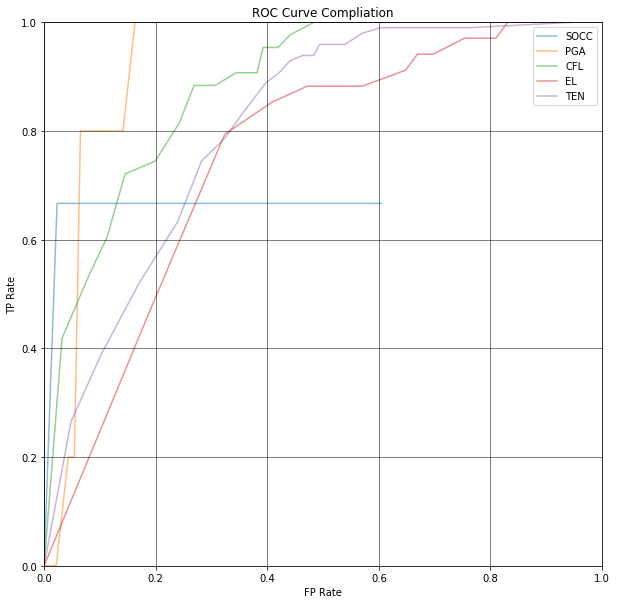

In [127]:
threshold = 500
sportRates = []
for sportObj in sportIds:
    if(len(sportObj['testDF'])<threshold):
        sportRates.append(sportObj['rates'])
plotRocs(sportRates)

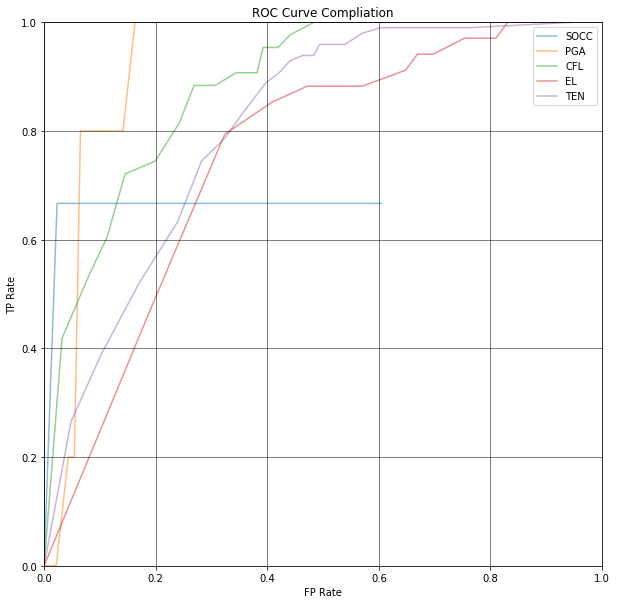

In [128]:
plotRocs(sportRates)

### LR Scale test

In [243]:
# lr_results = pd.read_csv('data/LR_Results.csv').set_index('ContestId')
# for c in lr_results.columns:
#     lr_results = lr_results.rename(columns={c:c[:-len('_Scaled')]})
# lr_Test = limitVal(pd.merge(lr_results, testDF[['Success']], on='ContestId', how='left').dropna(), N=1.)
# lr_Train = limitVal(pd.merge(lrs_results, trainDF[['Success']], on='ContestId', how='left').dropna(), N=1.)

In [244]:
# lr_Train.dtypes

In [123]:
# LR_Rate = getRate(avgVal(lr_Test), 'AvgPred', label='LR on Normal Data')
# plotRocThreshold(LR_Rate)

In [245]:
# LR__CLFS = EnsembleWithMinAcc(lr_Train, RandomForestClassifier, accuracy = .6)
# LR_Preds = avgVal(getEnsPred(lr_Train, LR_Scaled_CLFS))

In [247]:
# combinedEnsembleRates =  getRate(combinedPreds, 'AvgPred', label='Ensemble of LR+KF+Meta Prediction')
# plotRocThreshold(combinedEnsembleRates)

In [110]:
lrs_results = pd.read_csv('data/LR_Scaled_Results.csv').drop(columns=['Unnamed: 0']).set_index('ContestId')
lrs_Test = pd.merge(lrs_results, testDF[['Success']], on='ContestId', how='left').dropna()
lrs_Train = pd.merge(lrs_results, trainDF[['Success']], on='ContestId', how='left').dropna()

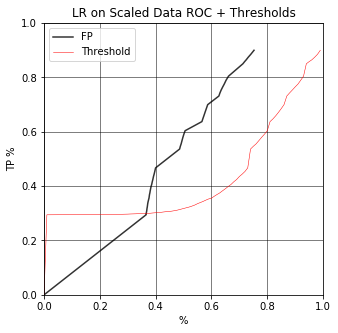

In [309]:
LR_Scaled_Rate = getRate(avgVal(limitVal(lrs, N=1.)), 'AvgPred', label='LR on Scaled Data')
plotRocThreshold(LR_Scaled_Rate)

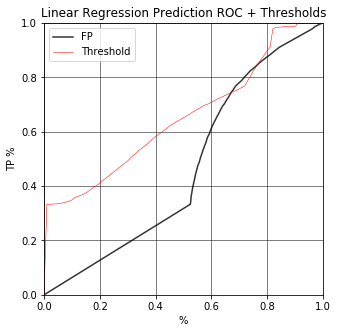

In [308]:
lrAvgRate = getRate(avgVal(limitVal(lrTest, N=1.)), 'AvgPred', label='Linear Regression Prediction')
plotRocThreshold(lrAvgRate)